# Compare behavior cloning

This notebook allows the visual comparison of various behavior cloning controllers, as shown in their verify runs. The notebook starts with an experiment that lists several bc verify type experiments. It is assumed that those experiments had been run before this notebook is running, because it is building on the results of those experiments. 

In [1]:
import sys
sys.path.append("..")

from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import pathlib
import pprint
import matplotlib.pyplot as plt

import numpy as np

In [2]:
experiment = "behavior_cloning"
run = "bc_compare_00"

exp = Config().get_experiment(experiment, run)
pprint.pprint(exp)

verification_run_exps = {}
for expname in exp["bc_verification_runs"]:
    verexp = Config().get_experiment(experiment, expname)
    verification_run_exps[expname] = verexp

***ExpRun**: Loading pointer config file:
	C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml
***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\behavior_cloning\bc_compare_00_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: behavior_cloning/bc_compare_00 successfully loaded
Experiment:
    bc_verification_runs:
    - bc_verify_lstm_00
    - bc_verify_mlp_00
    - bc_verify_lstm_mdn_00
    control_size: 6
    data_dir: c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\behavior_cloning\bc_compare_00
    epochs: 10
    exp_robot: robot_al5d
    exp_run_sys_indep_file: C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\behavior_cloning\bc_compare_00.yaml
    experiment_name: behavior

In [3]:
# load the saved data from the verifications
real_np = None
preds_nps = {}
for name in verification_run_exps:
    verexp = verification_run_exps[name]
    if real_np is None:
        real_path = pathlib.Path(verexp.data_dir(), "real.npy")
        real_np = np.load(real_path)
    pred_path =  pathlib.Path(verexp.data_dir(), "pred.npy")
    pred_np = np.load(pred_path)
    preds_nps[name] = pred_np

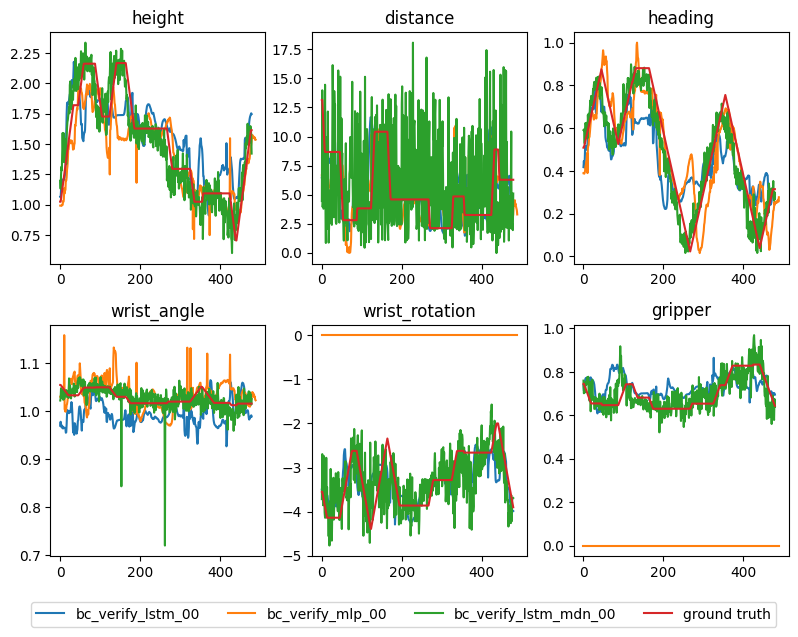

In [5]:
fig, axs = plt.subplots(2,3, figsize=(8, 6))
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
# for i in range(bcexp["control_size"]):
for i in range(6):
    ax = axs[i//3, i%3]
    # ax.set_ylim(0, 1.4)
    for name in preds_nps:
        ax.plot(preds_nps[name][:,i], label=name)
    ax.plot(real_np[:,i], label="ground truth")
    if i==0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, ncol=1+len(verification_run_exps),
            bbox_to_anchor=(0.5, 0), loc="upper center")
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(exp.data_dir(), "bccomparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')